In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import umap.umap_ as umap

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [150]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [151]:
#look at data
train.head()



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [152]:
train.loc[train["family_history_diabetes"] == 1, "diagnosed_diabetes"].value_counts()


diagnosed_diabetes
1.0    90706
0.0    13875
Name: count, dtype: int64

In [153]:
#look at how many categorical cols
train.select_dtypes(include=['category', 'object'])

#have 6 categorical cols, for now drop them, later employ ordinal and one hot encoder for instance of object or category

,gender,ethnicity,education_level,income_level,smoking_status,employment_status
0,Female,Hispanic,Highschool,Lower-Middle,Current,Employed
1,Female,White,Highschool,Upper-Middle,Never,Employed
2,Male,Hispanic,Highschool,Lower-Middle,Never,Retired
3,Female,White,Highschool,Lower-Middle,Current,Employed
4,Male,White,Highschool,Upper-Middle,Never,Retired
...,...,...,...,...,...,...
699995,Female,Hispanic,Postgraduate,Upper-Middle,Former,Employed
699996,Female,Hispanic,Graduate,Upper-Middle,Former,Employed
699997,Female,White,Graduate,Middle,Never,Employed
699998,Female,White,Highschool,Lower-Middle,Never,Retired


In [154]:
#drop non-numeric values
train_numerics = train.select_dtypes(include='number')

#check to make sure only numerics
train_numerics.dtypes

#only numerics left

id                                      int64
age                                     int64
alcohol_consumption_per_week            int64
physical_activity_minutes_per_week      int64
diet_score                            float64
sleep_hours_per_day                   float64
screen_time_hours_per_day             float64
bmi                                   float64
waist_to_hip_ratio                    float64
systolic_bp                             int64
diastolic_bp                            int64
heart_rate                              int64
cholesterol_total                       int64
hdl_cholesterol                         int64
ldl_cholesterol                         int64
triglycerides                           int64
family_history_diabetes                 int64
hypertension_history                    int64
cardiovascular_history                  int64
diagnosed_diabetes                    float64
dtype: object

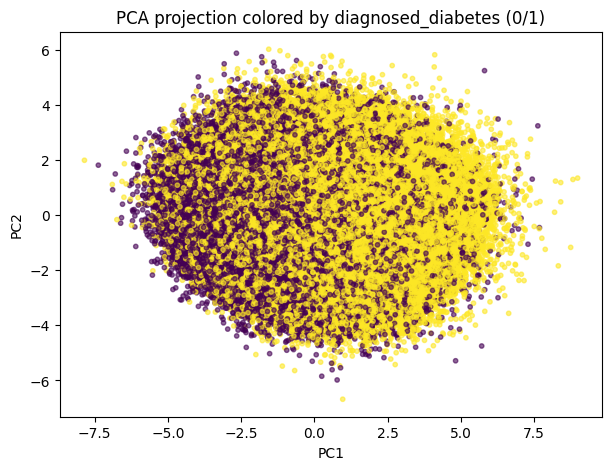

Explained variance ratio: [0.14603232 0.08918697] Total: 0.23521928565963007


In [155]:
#turn data into X and y
X = train_numerics.drop(columns=['diagnosed_diabetes'])

y = train_numerics['diagnosed_diabetes']



# X: feature dataframe, y: target series (0/1)
# adjust names to yours:

# scale
X_scaled = StandardScaler().fit_transform(X)

# reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, s=10, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection colored by diagnosed_diabetes (0/1)")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_, 
      "Total:", pca.explained_variance_ratio_.sum())



# (recommended) scale features first
#X_scaled = StandardScaler().fit_transform(X)

# fit UMAP -> 2D
# reducer = umap.UMAP(
#     n_neighbors=30,     # try 10, 30, 50
#     min_dist=0.1,       # try 0.0, 0.1, 0.5
#     n_components=2,
#     metric="euclidean",
#     random_state=42
# )

# X_umap = reducer.fit_transform(X_scaled)

# # plot
# plt.figure(figsize=(7,5))
# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=10, alpha=0.6)
# plt.title("UMAP projection colored by diagnosed_diabetes (0/1)")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.show()

In [156]:
# # (recommended) scale features first
# #X_scaled = StandardScaler().fit_transform(X)

# # fit UMAP -> 2D
# reducer = umap.UMAP(
#     n_neighbors=30,     # try 10, 30, 50
#     min_dist=0.1,       # try 0.0, 0.1, 0.5
#     n_components=2,
#     metric="euclidean",
#     random_state=42
# )

# X_umap = reducer.fit_transform(X_scaled)

# # plot
# plt.figure(figsize=(7,5))
# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=10, alpha=0.6)
# plt.title("UMAP projection colored by diagnosed_diabetes (0/1)")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.show()

In [157]:
# k = 15
# nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)  # use same X_scaled you used for UMAP
# idx = nbrs.kneighbors(return_distance=False)

# y_arr = y.to_numpy()
# pos = np.where(y_arr == 1)[0]

# # For each positive point, what fraction of its k neighbors are also positive?
# pos_neighbor_frac = y_arr[idx[pos]].mean(axis=1)
# print("Mean fraction of positive neighbors around positive points:", pos_neighbor_frac.mean())
# print("Overall positive rate:", y_arr.mean())

In [158]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 55, stratify=y)

In [159]:
#drop diabetes in family history due to too high of importance
X_train = X_train.drop(columns=['family_history_diabetes','id'])
X_test = X_test.drop(columns=['family_history_diabetes','id'])


#new test for importance in XGBoost
best_params = {
    "colsample_bytree": 0.7,
    "gamma": 0.1,
    "max_depth": 5,
    "min_child_weight": 3,
    "reg_lambda": 2.0,
    "subsample": 0.7
}

best_model = XGBClassifier(
    **best_params,
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

best_model.fit(X_train, y_train)


importance = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(25)

age                                   0.264874
physical_activity_minutes_per_week    0.227270
bmi                                   0.070328
triglycerides                         0.066921
ldl_cholesterol                       0.061477
systolic_bp                           0.044513
hdl_cholesterol                       0.033393
diet_score                            0.032853
cardiovascular_history                0.032369
heart_rate                            0.031129
waist_to_hip_ratio                    0.030286
cholesterol_total                     0.025403
screen_time_hours_per_day             0.021304
alcohol_consumption_per_week          0.016829
diastolic_bp                          0.014014
sleep_hours_per_day                   0.013988
hypertension_history                  0.013047
dtype: float32

In [160]:
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.6856620758506544


In [161]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos




# xgb = XGBClassifier(
#     n_estimators=500,
#     learning_rate=0.05,
#     scale_pos_weight=scale_pos_weight,
#     eval_metric="auc",
#     random_state=42,
#     n_jobs=-1
# )

best_params = {
    "colsample_bytree": 0.7,
    "gamma": 0.1,
    "max_depth": 5,
    "min_child_weight": 3,
    "reg_lambda": 2.0,
    "subsample": 0.7
}

best_model = XGBClassifier(
    **best_params,
    n_estimators=300,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

best_model.fit(X_train, y_train)

y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.6861154613913973


In [162]:
#recalculate best parms for XGBoost without family history

# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# scale_pos_weight = neg / pos

# param_grid = {
#     "max_depth": [3, 4, 5],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.3],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.7, 0.8, 0.9],
#     "reg_lambda": [1.0, 2.0, 5.0]
# }


# xgb = XGBClassifier(
#     n_estimators=500,
#     learning_rate=0.05,
#     scale_pos_weight=scale_pos_weight,
#     eval_metric="logloss",
#     #evalation_metric="auc",
#     random_state=42,
#     n_jobs=-1
# )

# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring="roc_auc",
#     cv=3,
#     verbose=2
# )

# grid.fit(X_train, y_train)

# print("Best CV ROC-AUC:", grid.best_score_)
# print("Best params:", grid.best_params_)

In [163]:
best_params = {
    "colsample_bytree": 0.7,
    "gamma": 0.1,
    "max_depth": 5,
    "min_child_weight": 1,
    "reg_lambda": 2.0,
    "subsample": 0.9
}

best_model = XGBClassifier(
    **best_params,
    n_estimators=300,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc"
)

best_model.fit(X_train, y_train)

y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.6856051534896396


In [164]:
importance = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(50)

age                                   0.279763
physical_activity_minutes_per_week    0.237392
triglycerides                         0.068907
bmi                                   0.066517
ldl_cholesterol                       0.061450
systolic_bp                           0.044178
diet_score                            0.032289
hdl_cholesterol                       0.030919
waist_to_hip_ratio                    0.029387
cardiovascular_history                0.028767
heart_rate                            0.027276
cholesterol_total                     0.024907
screen_time_hours_per_day             0.019334
alcohol_consumption_per_week          0.013809
hypertension_history                  0.012781
diastolic_bp                          0.011741
sleep_hours_per_day                   0.010582
dtype: float32

In [165]:
#run fast model and see results
Gnb = GaussianNB()

#fit the data
Gnb.fit(X_train, y_train)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [166]:
#predict on unknown and get accuracy
y_pred = Gnb.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)

print("accuracy is: ", accuracy)

#that is very bad accuracy

accuracy is:  0.6289


In [167]:
#operate on one hot encoder data only, not ordinal or numerical
train.head()
#income_level and education_level is only ordinal
#gender, ethnicity, smoking_status, employment_status is one hot encoder

#take out education_level

train = train.drop(columns='education_level')



In [168]:
train.head()
#can see we dropped education_level

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,102,Female,Hispanic,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,124,Female,White,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,108,Male,Hispanic,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,123,Female,White,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,124,Male,White,Upper-Middle,Never,Retired,0,1,0,1.0


In [169]:
#do one hot encoder on gender, ethnicity, smoking_status, employment_status

train_ohe = train.select_dtypes(include=['category', 'object'])
#drop income_level
train_ohe = train_ohe.drop(columns=['income_level'])
train_ohe.head()

,gender,ethnicity,smoking_status,employment_status
0,Female,Hispanic,Current,Employed
1,Female,White,Never,Employed
2,Male,Hispanic,Never,Retired
3,Female,White,Current,Employed
4,Male,White,Never,Retired


In [170]:
#do one hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform="pandas")

train_ohe = ohe.fit_transform(train_ohe)

train_ohe.head()

,gender_Female,gender_Male,gender_Other,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,smoking_status_Current,smoking_status_Former,smoking_status_Never,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [171]:
#do ordinal encoder on only income_level
train_ord = train[['income_level']]
#train_ord.head()

train_ord['income_level'].unique()

array(['Lower-Middle', 'Upper-Middle', 'Low', 'Middle', 'High'],
      dtype=object)

In [172]:
#ordinal encode this
income_order = ["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"]

ord_enc = OrdinalEncoder(categories=[income_order])
train_ord['income_order'] = ord_enc.fit_transform(train_ord[['income_level']])

train_ord.head(20)

C:\Users\Jackson Weaver\AppData\Local\Temp\ipykernel_20116\356347539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ord['income_order'] = ord_enc.fit_transform(train_ord[['income_level']])


,income_level,income_order
0,Lower-Middle,1.0
1,Upper-Middle,3.0
2,Lower-Middle,1.0
3,Lower-Middle,1.0
4,Upper-Middle,3.0
5,Lower-Middle,1.0
6,Lower-Middle,1.0
7,Low,0.0
8,Lower-Middle,1.0
9,Middle,2.0


In [173]:
#income_level and education_level is only ordinal
#gender, ethnicity, smoking_status, employment_status is one hot encoder



#above are columns I need to drop from original in order to add the one hot encoder and ordinal encoder
#forgot I already dropped education_level

train_ohe_ord = train.drop(columns=['gender', 'ethnicity', 'smoking_status', 'employment_status', 'income_level'])

In [174]:
#add ordinal and one hot encoder back

#add ohe
train_ohe_ord = pd.concat([train, train_ohe], axis = 1)
train_ohe_ord.head()
#check to make sure its added


#add ordinal

train_ohe_ord = pd.concat([train_ohe_ord, train_ord], axis = 1)

train_ohe_ord.head()
#drop income_level
#train_ohe_ord = train_ohe_ord.drop(columns='income_level')
train_ohe_ord = train.drop(columns=['gender', 'ethnicity', 'smoking_status', 'employment_status', 'income_level'])
train_ohe_ord.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,0,1,0,1.0


In [175]:
# Model
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",   # helps with imbalance
    random_state=42,
    n_jobs=-1
)

# Fit
rf.fit(X_train, y_train)

# Probabilities + ROC-AUC
y_prob = rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Test ROC-AUC: 0.6661136412447975


In [176]:
#get X's and y's and split data
X = train_ohe_ord.drop(columns='diagnosed_diabetes')

y = train_ohe_ord['diagnosed_diabetes']

In [177]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

In [178]:
X.columns
X.dtypes
X.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,0,1,0


In [179]:
#now run Gaussian on full dataset
Gnb2 = GaussianNB()
Gnb2.fit(X_train, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [180]:
y_pred = Gnb2.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)

print("accuracy is: ", accuracy)

#see that not much has changed, now do XGboost


accuracy is:  0.6447857142857143


In [181]:
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6757071428571428
[[20222 32517]
 [12884 74377]]
              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47     52739
         1.0       0.70      0.85      0.77     87261

    accuracy                           0.68    140000
   macro avg       0.65      0.62      0.62    140000
weighted avg       0.66      0.68      0.66    140000



In [182]:
train.head()

#lets try dropping a bunch of columns
train_drop = train.drop(columns= ['alcohol_consumption_per_week','age','screen_time_hours_per_day','bmi','income_level', 'ethnicity', 'smoking_status', 'employment_status','gender'])

In [183]:
X = train_drop.drop(columns='diagnosed_diabetes')

y = train_drop['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

In [184]:
train_drop.head()

Gnb3 = GaussianNB()
Gnb3.fit(X_train, y_train)

y_pred = Gnb3.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)

print("accuracy is: ", accuracy)



accuracy is:  0.6441428571428571


In [185]:
X_train.head(15)

,id,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
367515,367515,43,2.5,7.1,0.87,103,76,69,210,41,132,117,0,0,0
144583,144583,34,6.6,5.1,0.91,110,79,71,183,59,105,132,1,0,0
536724,536724,98,8.4,7.8,0.80,118,69,69,192,54,117,84,0,1,0
78907,78907,43,7.0,7.8,0.84,111,79,74,183,61,71,101,0,0,0
365251,365251,105,7.6,7.6,0.81,97,78,80,192,58,100,104,0,0,0
582674,582674,87,5.2,4.9,0.94,129,70,65,193,54,109,119,0,0,0
383580,383580,107,5.1,9.7,0.95,139,66,64,186,67,95,115,0,0,0
68057,68057,73,6.3,5.5,0.88,106,73,60,213,59,125,99,0,0,0
439063,439063,69,6.4,6.2,0.91,109,75,61,183,58,81,172,1,0,0
7337,7337,33,6.9,6.1,0.83,96,78,67,171,51,85,109,0,0,0


In [186]:
# xgb = XGBClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=4,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="logloss"
# )

# param_grid = {
#     "max_depth": [3, 4, 5],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.7, 0.8, 0.9],
#     "reg_lambda": [0.5, 1.0, 2.0],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.2],
#     "n_estimators": [200, 300, 500],
#     "learning_rate": [0.03, 0.05, 0.1],
# }

# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring="f1",     # or "roc_auc", "recall", etc.
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )


# grid.fit(X_train, y_train)

# print("Best score:", grid.best_score_)
# print("Best params:", grid.best_params_)

# best_model = grid.best_estimator_

In [187]:
# with parallel_backend("threading"):
#     grid.fit(X_train, y_train)

In [188]:
#researched more via chatgpt and found less columns matter, so redo, but with these columns

train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,102,Female,Hispanic,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,124,Female,White,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,108,Male,Hispanic,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,123,Female,White,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,124,Male,White,Upper-Middle,Never,Retired,0,1,0,1.0


In [189]:
train.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'income_level',
       'smoking_status', 'employment_status', 'family_history_diabetes',
       'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

In [190]:
#age

# bmi

# waist_to_hip_ratio (often very informative alongside BMI)

# family_history_diabetes

# physical_activity_minutes_per_week

# systolic_bp, diastolic_bp

# hypertension_history

# triglycerides

# hdl_cholesterol (often inversely related risk)

# cholesterol_total and/or ldl_cholesterol

In [191]:
#only keep bi, waist to hip, family_history_diabetes, physical_activity, systolic_bp, diastolic_bp, hyptertension, 
# trigylercides, hdl_cholesterol, cholesterol_total

df_new = train.copy()

df_new = df_new[['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total', 'diagnosed_diabetes']]
df_new.head()

#split the data

X = df_new.drop(columns='diagnosed_diabetes')

y = df_new['diagnosed_diabetes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)


In [192]:
#fit it on crappy gnb
Gnb_new = Gnb.fit(X_train, y_train)

y_pred = Gnb_new.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print("accuracy score is: " + str(accuracy))


accuracy score is: 0.62435


In [193]:
# xgb = XGBClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=4,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="logloss"
# )

# param_grid = {
#     "max_depth": [3, 4, 5],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.7, 0.8, 0.9],
#     "reg_lambda": [0.5, 1.0, 2.0],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.2],
#     "n_estimators": [200, 300, 500],
#     "learning_rate": [0.03, 0.05, 0.1],
# }

# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring="f1",     # or "roc_auc", "recall", etc.
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )


# grid.fit(X_train, y_train)

# print("Best score:", grid.best_score_)
# print("Best params:", grid.best_params_)

# best_model = grid.best_estimator_

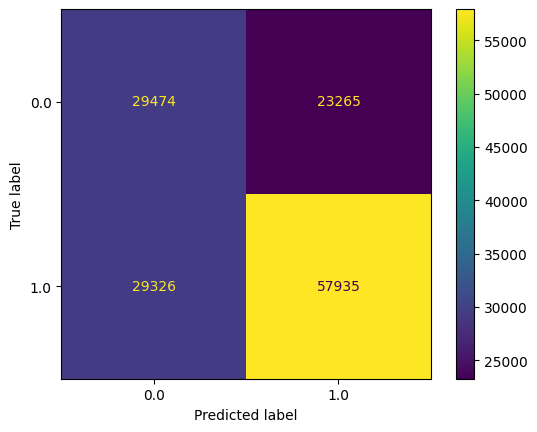

In [194]:
#only keep age, alcohol_consumption, physical_activity, sleep, bmi, waist_to_hip (might keep, might drop), systolic_bp, triglycerides, 

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


#as we can see below that our sensitivity is really bad

In [195]:
# xgb = XGBClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=4,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="logloss"
# )

# param_grid = {
#     "max_depth": [3, 4, 5],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.7, 0.8, 0.9],
#     "reg_lambda": [0.5, 1.0, 2.0],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.2]
#     # optional: "n_estimators": [200, 300, 500],
#     # optional: "learning_rate": [0.03, 0.05, 0.1],
# }

# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring="roc_auc",     # or "roc_auc", "recall", etc.
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )


# grid.fit(X_train, y_train)

# print("Best score:", grid.best_score_)
# print("Best params:", grid.best_params_)

# best_model = grid.best_estimator_

In [196]:
best_params = {
    "colsample_bytree": 0.7,
    "gamma": 0.1,
    "max_depth": 5,
    "min_child_weight": 3,
    "reg_lambda": 2.0,
    "subsample": 0.7
}

best_model = XGBClassifier(
    **best_params,
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [197]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


accuracy = accuracy_score(y_pred, y_test)
print("accuracy is: " + str(accuracy))

accuracy is: 0.6724071428571429


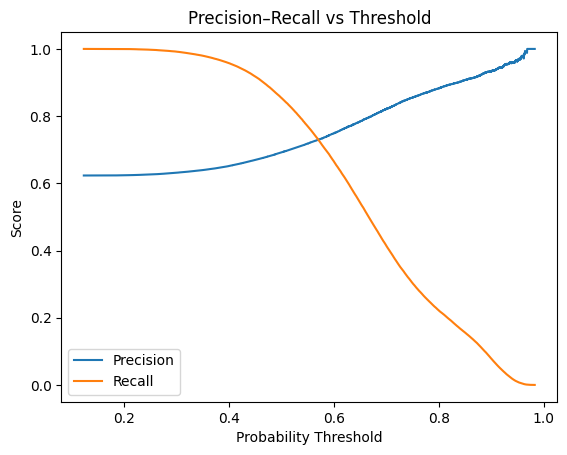

In [198]:
y_prob = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall vs Threshold")
plt.show()

In [199]:
chosen_threshold = 0.40  # or best_threshold from above
y_pred_custom = (y_prob >= chosen_threshold).astype(int)


print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

[[ 8110 44629]
 [ 3727 83534]]
              precision    recall  f1-score   support

         0.0       0.69      0.15      0.25     52739
         1.0       0.65      0.96      0.78     87261

    accuracy                           0.65    140000
   macro avg       0.67      0.56      0.51    140000
weighted avg       0.66      0.65      0.58    140000



In [200]:
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.7084491902801642


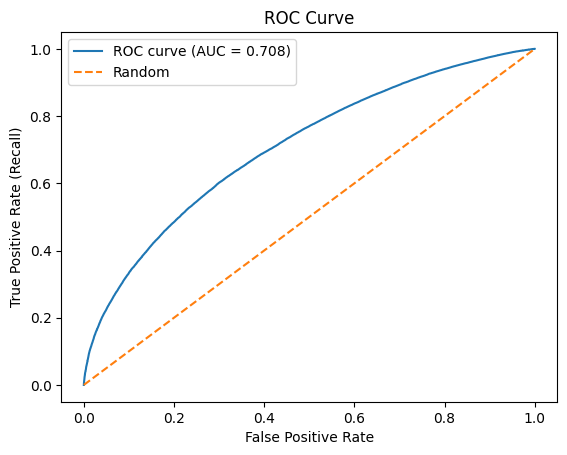

In [201]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [202]:
importance = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(15)

family_history_diabetes               0.862262
physical_activity_minutes_per_week    0.045816
systolic_bp                           0.023122
cholesterol_total                     0.013407
triglycerides                         0.013398
hypertension_history                  0.012650
bmi                                   0.012598
hdl_cholesterol                       0.008076
waist_to_hip_ratio                    0.005322
diastolic_bp                          0.003349
dtype: float32

In [203]:
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
mi_scores.head(15)

physical_activity_minutes_per_week    0.034581
family_history_diabetes               0.032665
waist_to_hip_ratio                    0.009684
hypertension_history                  0.008622
triglycerides                         0.008077
systolic_bp                           0.007654
bmi                                   0.006314
cholesterol_total                     0.004796
hdl_cholesterol                       0.004406
diastolic_bp                          0.003613
dtype: float64

In [204]:
import xgboost
import inspect
from xgboost import XGBClassifier

print("xgboost version:", xgboost.__version__)
print("fit signature:", inspect.signature(XGBClassifier.fit))

xgboost version: 3.1.2
fit signature: (self, X: Any, y: Any, *, sample_weight: Optional[Any] = None, base_margin: Optional[Any] = None, eval_set: Optional[Sequence[Tuple[Any, Any]]] = None, verbose: Union[bool, int, NoneType] = True, xgb_model: Union[xgboost.core.Booster, str, xgboost.sklearn.XGBModel, NoneType] = None, sample_weight_eval_set: Optional[Sequence[Any]] = None, base_margin_eval_set: Optional[Sequence[Any]] = None, feature_weights: Optional[Any] = None) -> 'XGBClassifier'


In [205]:

X_train.head()

,bmi,family_history_diabetes,waist_to_hip_ratio,physical_activity_minutes_per_week,systolic_bp,diastolic_bp,hypertension_history,triglycerides,hdl_cholesterol,cholesterol_total
377364,30.8,0,0.95,83,115,75,0,123,54,167
104200,20.1,0,0.76,74,102,73,0,109,61,169
414919,28.2,0,0.88,79,124,77,0,147,36,162
245356,21.8,0,0.82,209,129,66,0,97,49,163
354629,24.6,0,0.88,52,108,70,0,142,45,178


In [206]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# class imbalance weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos

# train/val split from training set
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# DMatrix (set enable_categorical=True only if your X has pandas category dtype)
dtr  = xgb.DMatrix(X_tr,  label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.03,                 # learning_rate
    "max_depth": 4,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,               # reg_lambda
    "gamma": 0.1,
    "scale_pos_weight": spw,
    "tree_method": "hist",
    "seed": 42,
}

bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=5000,
    evals=[(dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=False
)

# predict using best iteration
y_prob = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Best iteration (0-based):", bst.best_iteration)
print("Best val AUC:", bst.best_score)


Test ROC-AUC: 0.7125928758880783
Best iteration (0-based): 2219
Best val AUC: 0.7124175308669616


In [ ]:
# FEATURES = [
#     'bmi', 'family_history_diabetes', 'waist_to_hip_ratio',
#     'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp',
#     'hypertension_history', 'triglycerides', 'hdl_cholesterol',
#     'cholesterol_total'
# ]

# # Kaggle test features + ids
# X_kaggle = test[FEATURES].copy()
# test_ids = test["id"].copy()

# # Predict probabilities with your trained booster
# d_kaggle = xgb.DMatrix(X_kaggle)
# test_prob = bst.predict(d_kaggle, iteration_range=(0, bst.best_iteration + 1))

# # Convert to 0/1 because sample_submission is 0/1
# THRESHOLD = 0.5
# test_pred = (test_prob >= THRESHOLD).astype(int)

# # Build submission
# submission = pd.DataFrame({
#     "id": test_ids.values,
#     "diagnosed_diabetes": test_pred
# })

# print(len(submission), len(test))  # should match
# submission.to_csv("submission.csv", index=False)
# print(submission.head())
# print("Saved submission.csv")


300000 300000


PermissionError: [Errno 13] Permission denied: 'submission.csv'

In [ ]:
# import pandas as pd
# import xgboost as xgb

# FEATURES = [
#     'bmi', 'family_history_diabetes', 'waist_to_hip_ratio',
#     'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp',
#     'hypertension_history', 'triglycerides', 'hdl_cholesterol',
#     'cholesterol_total'
# ]

# X_kaggle = test[FEATURES].copy()
# d_kaggle = xgb.DMatrix(X_kaggle)

# # probabilities (0..1)
# test_prob = bst.predict(d_kaggle, iteration_range=(0, bst.best_iteration + 1))

# submission = pd.DataFrame({
#     "id": test["id"].values,
#     "diagnosed_diabetes": test_prob   # <-- PROBABILITIES, not 0/1
# })

# submission.to_csv("submission.csv", index=False)
# print(submission.head())
# print("Saved submission.csv")

ValueError: feature_names mismatch: ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total', 'chol_hdl_ratio', 'bp_ratio', 'pulse_pressure', 'trig_hdl_ratio'] ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total']
expected chol_hdl_ratio, bp_ratio, trig_hdl_ratio, pulse_pressure in input data

In [ ]:
test.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history'],
      dtype='object')

In [208]:
def add_engineered_features(df):
    df = df.copy()
    eps = 1e-6  # prevent divide-by-zero

    df["chol_hdl_ratio"] = df["cholesterol_total"] / (df["hdl_cholesterol"] + eps)
    df["bp_ratio"] = df["systolic_bp"] / (df["diastolic_bp"] + eps)
    df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]
    df["trig_hdl_ratio"] = df["triglycerides"] / (df["hdl_cholesterol"] + eps)

    return df



FEATURES = [
    'bmi',
    'family_history_diabetes',
    'waist_to_hip_ratio',
    'physical_activity_minutes_per_week',
    'systolic_bp',
    'diastolic_bp',
    'hypertension_history',
    'triglycerides',
    'hdl_cholesterol',
    'cholesterol_total',
    'chol_hdl_ratio',
    'bp_ratio',
    'pulse_pressure',
    'trig_hdl_ratio'
]



# Apply SAME feature engineering as training
test_feat = add_engineered_features(test)

X_kaggle = test_feat[FEATURES]
test_ids = test["id"].copy()

d_kaggle = xgb.DMatrix(X_kaggle)

test_prob = bst.predict(
    d_kaggle,
    iteration_range=(0, bst.best_iteration + 1)
)



submission = pd.DataFrame({
    "id": test_ids.values,
    "diagnosed_diabetes": test_prob
})

submission.to_csv("submission_new.csv", index=False)

print(submission.head())
print("Saved submission.csv")


ValueError: feature_names mismatch: ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total'] ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total', 'chol_hdl_ratio', 'bp_ratio', 'pulse_pressure', 'trig_hdl_ratio']
training data did not have the following fields: chol_hdl_ratio, bp_ratio, trig_hdl_ratio, pulse_pressure

In [ ]:
# FEATURES = [
#     'bmi', 'family_history_diabetes', 'waist_to_hip_ratio',
#     'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp',
#     'hypertension_history', 'triglycerides', 'hdl_cholesterol',
#     'cholesterol_total'
# ]

# # Kaggle test features + ids
# X_kaggle = test[FEATURES].copy()
# test_ids = test["id"].copy()

# # Predict probabilities with your trained booster
# d_kaggle = xgb.DMatrix(X_kaggle)
# test_prob = bst.predict(d_kaggle, iteration_range=(0, bst.best_iteration + 1))



# # Build submission
# submission = pd.DataFrame({
#     "id": test_ids.values,
#     "diagnosed_diabetes": test_prob
# })

# print(len(submission), len(test))  # should match
# submission.to_csv("submission.csv", index=False)
# print(submission.head())
# print("Saved submission.csv")

ValueError: feature_names mismatch: ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total', 'chol_hdl_ratio', 'bp_ratio', 'pulse_pressure', 'trig_hdl_ratio'] ['bmi', 'family_history_diabetes', 'waist_to_hip_ratio', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'hypertension_history', 'triglycerides', 'hdl_cholesterol', 'cholesterol_total']
expected chol_hdl_ratio, bp_ratio, trig_hdl_ratio, pulse_pressure in input data

In [ ]:
import xgboost as xgb

d_kaggle = xgb.DMatrix(X_kaggle)
test_prob = bst.predict(d_kaggle, iteration_range=(0, bst.best_iteration + 1))


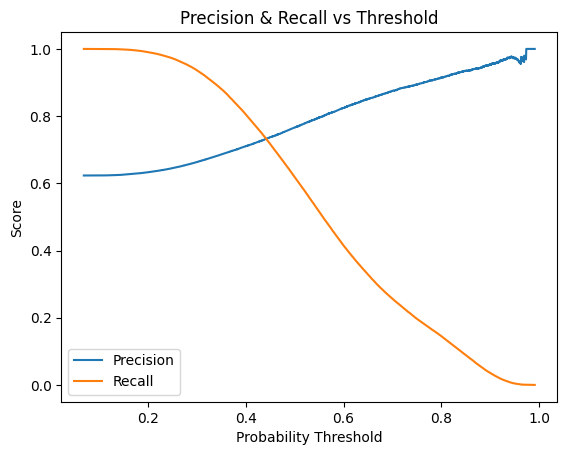

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# ---- Plot Precision & Recall vs Threshold ----
plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# ---- Choose threshold for screening ----
target_recall = 0.5
valid = np.where(recall[:-1] >= target_recall)[0]

idx = valid[-1]  # highest threshold that still meets recall target
chosen_threshold = thresholds[idx]

print("Chosen threshold:", chosen_threshold)
print("Precision:", precision[idx])
print("Recall:", recall[idx])

# ---- Apply threshold ----
y_pred = (y_prob >= chosen_threshold).astype(int)

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Chosen threshold: 0.55761325
Precision: 0.7997470489038786
Recall: 0.500005729936627

Confusion matrix:
 [[41814 10925]
 [43630 43631]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.49      0.79      0.61     52739
         1.0       0.80      0.50      0.62     87261

    accuracy                           0.61    140000
   macro avg       0.64      0.65      0.61    140000
weighted avg       0.68      0.61      0.61    140000



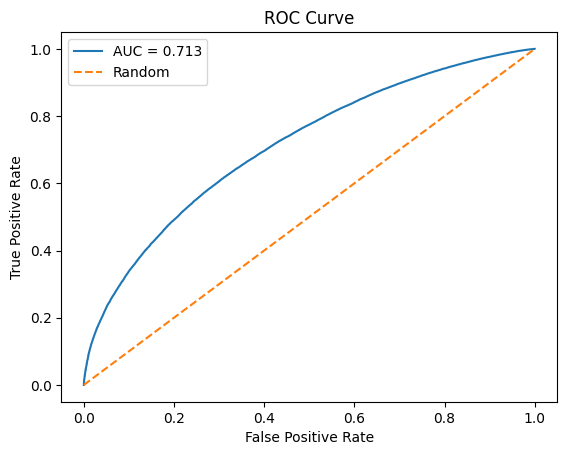

ROC-AUC: 0.7126095428883674


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thr = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


roc = roc_auc_score(y_test, y_prob)   # y_prob = model probabilities
print("ROC-AUC:", roc)


In [ ]:
# # --- Create submission file ---
# submission = pd.DataFrame({
#     IDCOL: test_ids,
#     TARGET: test_prob   # Kaggle often wants probability for the positive class
# })

# submission.to_csv("submission.csv", index=False)
# print(submission.head())
# print("Saved: submission.csv")

NameError: name 'IDCOL' is not defined

In [ ]:
# # Predict probabilities
# test_prob = bst.predict(dtest)

# THRESHOLD = 0.5   # change to 0.32 if you want more positives

# test_pred = (test_prob >= THRESHOLD).astype(int)
# submission = pd.DataFrame({
#     "id": test["id"],
#     "diagnosed_diabetes": test_pred
# })

# submission.to_csv("submission.csv", index=False)

# print(submission.head())
# print("Saved submission.csv")



ValueError: array length 140000 does not match index length 300000

In [ ]:
# # 1) grab ids from the Kaggle test set
# test_ids = test["id"].copy()

# # 2) build submission (Kaggle wants id + your prediction column)
# submission = pd.DataFrame({
#     "id": test_ids,
#     "diagnosed_diabetes": test_prob   # predicted probabilities
# })

# submission.to_csv("submission.csv", index=False)
# print(submission.head())
# print("Saved submission.csv")

NameError: name 'test_prob' is not defined

In [ ]:
# def add_features(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()
#     if {"cholesterol_total","hdl_cholesterol"}.issubset(df.columns):
#         df["chol_hdl_ratio"] = df["cholesterol_total"] / (df["hdl_cholesterol"] + 1)
#     if {"systolic_bp","diastolic_bp"}.issubset(df.columns):
#         df["bp_ratio"] = df["systolic_bp"] / (df["diastolic_bp"] + 1)
#         df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]
#     if {"bmi","age"}.issubset(df.columns):
#         df["bmi_age"] = df["bmi"] * df["age"]
#     if {"triglycerides","hdl_cholesterol"}.issubset(df.columns):
#         df["trig_hdl_ratio"] = df["triglycerides"] / (df["hdl_cholesterol"] + 1)
#     return df

# X = add_features(X)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# spw = neg / pos

# # Make a validation set from training
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# xgb = XGBClassifier(
#     n_estimators=5000,          # high on purpose; early stopping will pick best
#     learning_rate=0.03,
#     max_depth=4,
#     min_child_weight=3,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=2.0,
#     gamma=0.1,
#     scale_pos_weight=spw,
#     eval_metric="auc",
#     random_state=42,
#     n_jobs=-1,
#     tree_method="hist"
# )

# xgb.fit(
#     X_tr, y_tr,
#     eval_set=[(X_val, y_val)],
#     verbose=False
# )

# y_prob = xgb.predict_proba(X_test)[:, 1]
# print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
# print("Best trees used:", xgb.best_iteration)



Test ROC-AUC: 0.7122841994139119


AttributeError: `best_iteration` is only defined when early stopping is used.